In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

def get_random_walk_noise_for_position_sequence(
        position_sequence: torch.tensor,
        noise_std_last_step):
  velocity_sequence = time_diff(position_sequence)
  num_velocities = velocity_sequence.shape[1]
  velocity_sequence_noise = torch.randn(
      list(velocity_sequence.shape)) * (noise_std_last_step/num_velocities**0.5)
  velocity_sequence_noise = torch.cumsum(velocity_sequence_noise, dim=1)
  position_sequence_noise = torch.cat([
      torch.zeros_like(velocity_sequence_noise[:, 0:1]),
      torch.cumsum(velocity_sequence_noise, dim=1)], dim=1)

  return position_sequence_noise

In [ ]:
import os
import torch
# os.environ['TORCH'] = torch.version
# print(torch.version)

!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.2.1+cu121.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install -q torch_scatter -f https://data.pyg.org/whl/torch-2.2.1+cu121.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.0 MB/s eta 0:00:00


In [ ]:
# !pip install torch-cluster
# !pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl size=714413 sha256=76a71814cc7ec1b95c55a0481ca7e01ce3cfe31d410059c9f636fb40581cac63
  Stored in directory: /root/.cache/pip/wheels/51/78/c3/536637b3cdcc3313aa5e8851a6c72b97f6a01877e68c7595e3
Successfully built torch-cluster
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00


In [ ]:
from typing import List
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
import math
import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                layer.bias.data.fill_(0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def build_mlp(
        input_size: int,
        hidden_layer_sizes: List[int],
        output_size: int = None,
        output_activation: nn.Module = nn.Identity,
        activation: nn.Module = nn.ReLU) -> nn.Module:
  # Size of each layer
  layer_sizes = [input_size] + hidden_layer_sizes
  if output_size:
    layer_sizes.append(output_size)

  # Number of layers
  nlayers = len(layer_sizes) - 1

  # Create a list of activation functions and
  # set the last element to output activation function
  act = [activation for i in range(nlayers)]
  act[-1] = output_activation

  # Create a torch sequential container
  mlp = nn.Sequential()
  for i in range(nlayers):
    mlp.add_module("NN-" + str(i), nn.Linear(layer_sizes[i],
                                             layer_sizes[i + 1]))
    mlp.add_module("Act-" + str(i), act[i]())

  return mlp


class Encoder(nn.Module):\
  def __init__(
          self,
          nnode_in_features: int,
          nnode_out_features: int,
          nedge_in_features: int,
          nedge_out_features: int,
          nmlp_layers: int,
          mlp_hidden_dim: int):
    super(Encoder, self).__init__()
    # Encode node features as an MLP
    self.node_fn = nn.Sequential(*[build_mlp(nnode_in_features,
                                             [mlp_hidden_dim
                                              for _ in range(nmlp_layers)],
                                             nnode_out_features),
                                   nn.LayerNorm(nnode_out_features)])
    # Encode edge features as an MLP
    self.edge_fn = nn.Sequential(*[build_mlp(nedge_in_features,
                                             [mlp_hidden_dim
                                              for _ in range(nmlp_layers)],
                                             nedge_out_features),
                                   nn.LayerNorm(nedge_out_features)])

  def forward(
          self,
          x: torch.tensor,
          edge_features: torch.tensor):
    return self.node_fn(x), self.edge_fn(edge_features)

##Multi-dimension Edge Features, Edge Feautre Embedding
class InteractionNetwork(MessagePassing):
  def __init__(
      self,
      nnode_in: int,
      nnode_out: int,
      nedge_in: int,
      nedge_out: int,
      nmlp_layers: int,
      mlp_hidden_dim: int,
  ):
    # Aggregate features from neighbors
    super(InteractionNetwork, self).__init__(aggr='add')
    # Node MLP
    self.node_fn = nn.Sequential(*[build_mlp(nnode_in + nedge_out,
                                             [mlp_hidden_dim
                                              for _ in range(nmlp_layers)],
                                             nnode_out),
                                   nn.LayerNorm(nnode_out)])
    # Edge MLP
    self.edge_fn = nn.Sequential(*[build_mlp(nnode_in + nnode_in + nedge_in,
                                             [mlp_hidden_dim
                                              for _ in range(nmlp_layers)],
                                             nedge_out),
                                   nn.LayerNorm(nedge_out)])

  def forward(self,
              x: torch.tensor,
              edge_index: torch.tensor,
              edge_features: torch.tensor):
    # Save particle state and edge features
    x_residual = x
    edge_features_residual = edge_features
    x, edge_features = self.propagate(
        edge_index=edge_index, x=x, edge_features=edge_features)

    return x + x_residual, edge_features + edge_features_residual

  def message(self,
              x_i: torch.tensor,
              x_j: torch.tensor,
              edge_features: torch.tensor) -> torch.tensor:
    # Concat edge features with a final shape of [nedges, latent_dim*3]
    # print('hello')
    # print("x_i", x_i.shape)
    # print("x_j", x_j.shape)

    # print("1", edge_features.shape)
    edge_features = torch.cat([x_i, x_j, edge_features], dim=-1)
    # print("2", edge_features.shape)
    edge_features = self.edge_fn(edge_features)
    # print("3", edge_features.shape)
    return edge_features

  def update(self,
             x_updated: torch.tensor,
             x: torch.tensor,
             edge_features: torch.tensor):
    x_updated = torch.cat([x_updated, x], dim=-1)
    x_updated = self.node_fn(x_updated)
    return x_updated, edge_features

class Processor(MessagePassing):
  def __init__(
      self,
      nnode_in: int,
      nnode_out: int,
      nedge_in: int,
      nedge_out: int,
      nmessage_passing_steps: int,
      nmlp_layers: int,
      mlp_hidden_dim: int,
  ):
    super(Processor, self).__init__(aggr='max')
    self.gnn_stacks = nn.ModuleList([
        InteractionNetwork(
            nnode_in=nnode_in,
            nnode_out=nnode_out,
            nedge_in=nedge_in,
            nedge_out=nedge_out,
            nmlp_layers=nmlp_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        ) for _ in range(nmessage_passing_steps)])

  def forward(self,
              x: torch.tensor,
              edge_index: torch.tensor,
              edge_features: torch.tensor):
    for gnn in self.gnn_stacks:
      x, edge_features = gnn(x, edge_index, edge_features)
    return x, edge_features


class Decoder(nn.Module):
  def __init__(
          self,
          nnode_in: int,
          nnode_out: int,
          nmlp_layers: int,
          mlp_hidden_dim: int):
    super(Decoder, self).__init__()
    self.node_fn = build_mlp(
        nnode_in, [mlp_hidden_dim for _ in range(nmlp_layers)], nnode_out)

  def forward(self,
              x: torch.tensor):
    return self.node_fn(x)


class EncodeProcessDecode(nn.Module):
  def __init__(
      self,
      nnode_in_features: int,
      nnode_out_features: int,
      nedge_in_features: int,
      latent_dim: int,
      nmessage_passing_steps: int,
      nmlp_layers: int,
      mlp_hidden_dim: int,
  ):
    super(EncodeProcessDecode, self).__init__()
    self._encoder = Encoder(
        nnode_in_features=nnode_in_features,
        nnode_out_features=latent_dim,
        nedge_in_features=nedge_in_features,
        nedge_out_features=latent_dim,
        nmlp_layers=nmlp_layers,
        mlp_hidden_dim=mlp_hidden_dim,
    )
    self._processor = Processor(
        nnode_in=latent_dim,
        nnode_out=latent_dim,
        nedge_in=latent_dim,
        nedge_out=latent_dim,
        nmessage_passing_steps=nmessage_passing_steps,
        nmlp_layers=nmlp_layers,
        mlp_hidden_dim=mlp_hidden_dim,
    )
    self._decoder = Decoder(
        nnode_in=latent_dim,
        nnode_out=nnode_out_features,
        nmlp_layers=nmlp_layers,
        mlp_hidden_dim=mlp_hidden_dim,
    )

  def forward(self,
              x: torch.tensor,
              edge_index: torch.tensor,
              edge_features: torch.tensor):
    # print("asdfasf")
    # print(x.shape)
    # print(edge_index.shape)
    # print(edge_features.shape)
    x, edge_features = self._encoder(x, edge_features)
    # print('fdgjytjydyj')
    # print(x.shape,edge_features.shape)
    x, edge_features = self._processor(x, edge_index, edge_features)
    # print('fdgjytjydyj')
    # print(x.shape,edge_features.shape)
    x = self._decoder(x)
    return x

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.nn import radius_graph
from typing import Dict


class LearnedSimulator(nn.Module):

  def __init__(
          self,
          particle_dimensions: int,
          nnode_in: int,
          nedge_in: int,
          latent_dim: int,
          nmessage_passing_steps: int,
          nmlp_layers: int,
          mlp_hidden_dim: int,
          connectivity_radius: float,
          boundaries: np.ndarray,
          normalization_stats: dict,
          nparticle_types: int,
          particle_type_embedding_size: int,
          boundary_clamp_limit: float = 1.0,
          device="cpu"
  ):
    super(LearnedSimulator, self).__init__()
    self._boundaries = boundaries
    self._connectivity_radius = connectivity_radius
    self._normalization_stats = normalization_stats
    self._nparticle_types = nparticle_types
    self._boundary_clamp_limit = boundary_clamp_limit

    # Particle type embedding has shape (9, 16)
    self._particle_type_embedding = nn.Embedding(
        nparticle_types, particle_type_embedding_size)

    # Initialize the EncodeProcessDecode
    self._encode_process_decode = EncodeProcessDecode(
        nnode_in_features=nnode_in,
        nnode_out_features=particle_dimensions,
        nedge_in_features=nedge_in,
        latent_dim=latent_dim,
        nmessage_passing_steps=nmessage_passing_steps,
        nmlp_layers=nmlp_layers,
        mlp_hidden_dim=mlp_hidden_dim)

    self._device = device

  def forward(self):
    pass

  def _compute_graph_connectivity(
          self,
          node_features: torch.tensor,
          nparticles_per_example: torch.tensor,
          radius: float,
          add_self_edges: bool = True):
    # Specify examples id for particles
    batch_ids = torch.cat(
        [torch.LongTensor([i for _ in range(n)])
         for i, n in enumerate(nparticles_per_example)]).to(self._device)
    # print("Btach_IDs:",batch_ids.shape)
    # radius_graph accepts r < radius not r <= radius
    # A torch tensor list of source and target nodes with shape (2, nedges)
    edge_index = radius_graph(
        node_features, r=radius, batch=batch_ids, loop=add_self_edges, max_num_neighbors=128)
    # print("Edge_Index", edge_index)
    # The flow direction when using in combination with message passing is
    # "source_to_target"
    receivers = edge_index[0, :]
    senders = edge_index[1, :]
    # print("Rec", receivers.shape)
    # print(rec)
    # print("Sen", senders.shape)
    return receivers, senders

  def _encoder_preprocessor(
          self,
          position_sequence: torch.tensor,
          nparticles_per_example: torch.tensor,
          particle_types: torch.tensor,
          material_property: torch.tensor = None):
    nparticles = position_sequence.shape[0]
    # print("N_particles:",nparticles)
    most_recent_position = position_sequence[:, -1]  # (n_nodes, 2)
    velocity_sequence = time_diff(position_sequence)
    # print("Velocity_sequence",velocity_sequence.shape)
    # Get connectivity of the graph with shape of (nparticles, 2)
    senders, receivers = self._compute_graph_connectivity(
        most_recent_position, nparticles_per_example, self._connectivity_radius)
    node_features = []
    # print(velocity_sequence.device)
    # print(self._normalization_stats.device)
    # Normalized velocity sequence, merging spatial an time axis.
    velocity_stats = self._normalization_stats["velocity"]
    normalized_velocity_sequence = (
        velocity_sequence - velocity_stats['mean']) / velocity_stats['std']
    flat_velocity_sequence = normalized_velocity_sequence.view(
        nparticles, -1)
    node_features.append(flat_velocity_sequence)
    # print("1:")
    # for i in node_features:
    #   print(len(i))
    boundaries = torch.tensor(
        self._boundaries, requires_grad=False).float().to(self._device)
    # print(boundaries)
    # print(most_recent_position==senders)
    # print(most_recent_position.shape)
    distance_to_lower_boundary = (
        most_recent_position - boundaries[:, 0][None])
    distance_to_upper_boundary = (
        boundaries[:, 1][None] - most_recent_position)
    distance_to_boundaries = torch.cat(
        [distance_to_lower_boundary, distance_to_upper_boundary], dim=1)
    # print("shpape:",distance_to_boundaries.shape)
    normalized_clipped_distance_to_boundaries = torch.clamp(
        distance_to_boundaries / self._connectivity_radius,
        -self._boundary_clamp_limit, self._boundary_clamp_limit)
    # The distance to 4 boundaries (top/bottom/left/right)
    # node_features shape (nparticles, 10+4)
    node_features.append(normalized_clipped_distance_to_boundaries)
    # print("2:")
    # for i in node_features:
    #   print(len(i))
    #   print(len(i[0]))
    # Particle type
    if self._nparticle_types > 1:
      particle_type_embeddings = self._particle_type_embedding(
          particle_types)
      node_features.append(particle_type_embeddings)

    # Material property
    if material_property is not None:
        material_property = material_property.view(nparticles, 1)
        node_features.append(material_property)
    # Collect edge features.
    edge_features = []
    normalized_relative_displacements = (
        most_recent_position[senders, :] -
        most_recent_position[receivers, :]
    ) / self._connectivity_radius

    # print("1normdim", normalized_relative_displacements.shape, len(normalized_relative_displacements[0]))
    edge_features.append(normalized_relative_displacements)

    # Add relative distance between 2 particles with shape (nparticles, 1)
    # Edge features has a final shape of (nparticles, ndim + 1)
    normalized_relative_distances = torch.norm(
        normalized_relative_displacements, dim=-1, keepdim=True)
    edge_features.append(normalized_relative_distances)

    # print("qwerty", torch.stack([senders, receivers]).shape)
    return (torch.cat(node_features, dim=-1),
            torch.stack([senders, receivers]),
            torch.cat(edge_features, dim=-1))

  def _decoder_postprocessor(
          self,
          normalized_acceleration: torch.tensor,
          position_sequence: torch.tensor) -> torch.tensor:
    # Extract real acceleration values from normalized values
    acceleration_stats = self._normalization_stats["acceleration"]
    acceleration = (
        normalized_acceleration * acceleration_stats['std']
    ) + acceleration_stats['mean']
    most_recent_position = position_sequence[:, -1]
    most_recent_velocity = most_recent_position - position_sequence[:, -2]
    new_velocity = most_recent_velocity + acceleration  # * dt = 1
    new_position = most_recent_position + new_velocity  # * dt = 1
    return new_position

  def predict_positions(
          self,
          current_positions: torch.tensor,
          nparticles_per_example: torch.tensor,
          particle_types: torch.tensor,
          material_property: torch.tensor = None) -> torch.tensor:
    if material_property is not None:
        node_features, edge_index, edge_features = self._encoder_preprocessor(
            current_positions, nparticles_per_example, particle_types, material_property)
    else:
        node_features, edge_index, edge_features = self._encoder_preprocessor(
            current_positions, nparticles_per_example, particle_types)
    predicted_normalized_acceleration = self._encode_process_decode(
        node_features, edge_index, edge_features)
    next_positions = self._decoder_postprocessor(
        predicted_normalized_acceleration, current_positions)
    # next_positions=predicted_normalized_acceleration
    return next_positions

  def predict_accelerations(
          self,
          next_positions: torch.tensor,
          position_sequence_noise: torch.tensor,
          position_sequence: torch.tensor,
          nparticles_per_example: torch.tensor,
          particle_types: torch.tensor,
          material_property: torch.tensor = None):

    # Add noise to the input position sequence.
    noisy_position_sequence = position_sequence + position_sequence_noise
    # print("noisy_posi_shape", noisy_position_sequence.shape)
    # print("noisy", position_sequence_noise)
    # print("noi/syshape", position_sequence)
    # Perform the forward pass with the noisy position sequence.
    if material_property is not None:
        node_features, edge_index, edge_features = self._encoder_preprocessor(
            noisy_position_sequence, nparticles_per_example, particle_types, material_property)
    else:
        node_features, edge_index, edge_features = self._encoder_preprocessor(
            noisy_position_sequence, nparticles_per_example, particle_types)

    predicted_normalized_acceleration = self._encode_process_decode(
        node_features, edge_index, edge_features)
    next_position_adjusted = next_positions + position_sequence_noise[:, -1]
    # print("next_psito",next_position_adjusted.shape)
    target_normalized_acceleration = self._inverse_decoder_postprocessor(
        next_position_adjusted, noisy_position_sequence)

    return predicted_normalized_acceleration, target_normalized_acceleration

  def _inverse_decoder_postprocessor(
          self,
          next_position: torch.tensor,
          position_sequence: torch.tensor):
    previous_position = position_sequence[:, -1]
    previous_velocity = previous_position - position_sequence[:, -2]
    next_velocity = next_position - previous_position
    acceleration = next_velocity - previous_velocity

    acceleration_stats = self._normalization_stats["acceleration"]
    normalized_acceleration = (
        acceleration - acceleration_stats['mean']) / acceleration_stats['std']
    return normalized_acceleration

  def save(
          self,
          path: str = 'model.pt'):
    torch.save(self.state_dict(), path)

  def load(
          self,
          path: str):
    self.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


def time_diff(
        position_sequence: torch.tensor) -> torch.tensor:
  return position_sequence[:, 1:] - position_sequence[:, :-1]

In [ ]:
import torch
import numpy as np


def load_npz_data(path):
    with np.load(path, allow_pickle=True) as data_file:
        if 'gns_data' in data_file:
            data = data_file['gns_data']
        elif('arr_0' in data_file):
            data=data_file['arr_0']
        else:
            data = [item for _, item in data_file.items()]
    return data


class SamplesDataset(torch.utils.data.Dataset):

    def __init__(self, path, input_length_sequence):
        super().__init__()
        self._data = load_npz_data(path)
        self._dimension = self._data[0][0].shape[-1]
        self._input_length_sequence = input_length_sequence
        self._material_property_as_feature = True if len(self._data[0]) >= 3 else False
        # print(len(self._data[0]))
        if self._material_property_as_feature:  # if raw data includes material_property
            self._data_lengths = [x.shape[0] - self._input_length_sequence for x, _, _ in self._data]
        else:
            self._data_lengths = [x.shape[0] - self._input_length_sequence for x, _, in self._data]
        self._length = sum(self._data_lengths)
        self._precompute_cumlengths = [sum(self._data_lengths[:x]) for x in range(1, len(self._data_lengths) + 1)]
        self._precompute_cumlengths = np.array(self._precompute_cumlengths, dtype=int)

    def __len__(self):
        return self._length

    def __getitem__(self, idx):
        # Select the trajectory immediately before
        # the one that exceeds the idx
        # (i.e., the one in which idx resides).
        trajectory_idx = np.searchsorted(self._precompute_cumlengths - 1, idx, side="left")

        # Compute index of pick along time-dimension of trajectory.
        start_of_selected_trajectory = self._precompute_cumlengths[trajectory_idx - 1] if trajectory_idx != 0 else 0
        time_idx = self._input_length_sequence + (idx - start_of_selected_trajectory)

        # Prepare training data.
        positions = self._data[trajectory_idx][0][time_idx - self._input_length_sequence:time_idx]
        positions = np.transpose(positions, (1, 0, 2))  # nparticles, input_sequence_length, dimension
        particle_type = np.full(positions.shape[0], self._data[trajectory_idx][1], dtype=int)
        n_particles_per_example = positions.shape[0]
        label = self._data[trajectory_idx][0][time_idx]

        if self._material_property_as_feature:  # if raw data includes material_property
            material_property = np.full(positions.shape[0], self._data[trajectory_idx][2], dtype=float)
            training_example = ((positions, particle_type, material_property, n_particles_per_example), label)
        else:
            training_example = ((positions, particle_type, n_particles_per_example), label)

        return training_example


def collate_fn(data):
    material_property_as_feature = True if len(data[0][0]) >= 4 else False
    position_list = []
    particle_type_list = []
    if material_property_as_feature:
        material_property_list = []
    n_particles_per_example_list = []
    label_list = []

    if material_property_as_feature:
        for ((positions, particle_type, material_property, n_particles_per_example), label) in data:
            position_list.append(positions)
            particle_type_list.append(particle_type)
            material_property_list.append(material_property)
            n_particles_per_example_list.append(n_particles_per_example)
            label_list.append(label)
    else:
        for ((positions, particle_type, n_particles_per_example), label) in data:
            position_list.append(positions)
            particle_type_list.append(particle_type)
            n_particles_per_example_list.append(n_particles_per_example)
            label_list.append(label)

    if material_property_as_feature:
        collated_data = (
            (
                torch.tensor(np.vstack(position_list)).to(torch.float32).contiguous(),
                torch.tensor(np.concatenate(particle_type_list)).contiguous(),
                torch.tensor(np.concatenate(material_property_list)).to(torch.float32).contiguous(),
                torch.tensor(n_particles_per_example_list).contiguous(),
            ),
            torch.tensor(np.vstack(label_list)).to(torch.float32).contiguous()
        )
    else:
        collated_data = (
            (
                torch.tensor(np.vstack(position_list)).to(torch.float32).contiguous(),
                torch.tensor(np.concatenate(particle_type_list)).contiguous(),
                torch.tensor(n_particles_per_example_list).contiguous(),
            ),
            torch.tensor(np.vstack(label_list)).to(torch.float32).contiguous()
        )

    return collated_data


class TrajectoriesDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        super().__init__()
        # load dataset stored in npz format
        # data is loaded as dict of tuples
        # of the form (positions, particle_type)
        # convert to list of tuples
        # TODO (jpv): allow_pickle=True is potential security risk. See docs.
        self._data = load_npz_data(path)
        self._dimension = self._data[0][0].shape[-1]
        self._length = len(self._data)
        self._material_property_as_feature = True if len(self._data[0]) >= 3 else False

    def __len__(self):
        return self._length

    def __getitem__(self, idx):
        if self._material_property_as_feature:
            positions, _particle_type, _material_property = self._data[idx]
            positions = np.transpose(positions, (1, 0, 2))
            particle_type = np.full(positions.shape[0], _particle_type, dtype=int)
            material_property = np.full(positions.shape[0], _material_property, dtype=float)
            n_particles_per_example = positions.shape[0]

            trajectory = (
                torch.tensor(positions).to(torch.float32).contiguous(),
                torch.tensor(particle_type).contiguous(),
                torch.tensor(material_property).to(torch.float32).contiguous(),
                n_particles_per_example
            )
        else:
            positions, _particle_type = self._data[idx]
            positions = np.transpose(positions, (1, 0, 2))
            particle_type = np.full(positions.shape[0], _particle_type, dtype=int)
            n_particles_per_example = positions.shape[0]

            trajectory = (
                torch.tensor(positions).to(torch.float32).contiguous(),
                torch.tensor(particle_type).contiguous(),
                n_particles_per_example
            )

        return trajectory


def get_data_loader_by_samples(path, input_length_sequence, batch_size, shuffle=False):
    dataset = SamplesDataset(path, input_length_sequence)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                                       pin_memory=True, collate_fn=collate_fn)


def get_data_loader_by_trajectories(path):
    dataset = TrajectoriesDataset(path)
    return torch.utils.data.DataLoader(dataset, batch_size=None, shuffle=False,
                                       pin_memory=True)

#READING_UTILS.PY

In [ ]:
import os
import json

def read_metadata(data_path: str,
                  purpose: str,
                  file_name: str = "metadata.json"):
  try:
    with open(os.path.join(data_path, file_name), 'rt') as fp:
      # New version use separate metadata for `train` and `rollout`.
      metadata = json.loads(fp.read())[purpose]

  except:
    with open(os.path.join(data_path, file_name), 'rt') as fp:
      # The previous format of the metadata does not distinguish the purpose of metadata
      metadata = json.loads(fp.read())

  return metadata

def flags_to_dict(FLAGS):
  flags_dict = {}
  for name in FLAGS:
    flag_value = FLAGS[name].value
    flags_dict[name] = flag_value
  return flags_dict

#TRAIN.PY


In [ ]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

In [ ]:
import collections
import json
import os
import pickle
import glob
import re
import gc
import sys
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from tqdm import tqdm
from absl import flags
from absl import app

del_all_flags(flags.FLAGS)
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
# del flags
flags.DEFINE_enum(
    'mode', 'rollout', ['train', 'valid', 'rollout'],
    help='Train model, validation or rollout evaluation.')
flags.DEFINE_integer('batch_size', 2, help='The batch size.')
flags.DEFINE_float('noise_std', 6.7e-4, help='The std deviation of the noise.')
flags.DEFINE_string('data_path','/content/drive/MyDrive/', help='The dataset directory.')
# flags.DEFINE_string('data_path','/content/', help='The dataset directory.')
flags.DEFINE_string('model_path', '/content/drive/MyDrive/models/', help=('The path for saving checkpoints of the model.'))
flags.DEFINE_string('output_path', '/content/drive/MyDrive/rollouts-106500_num_1_timestamp_100/test/', help='The path for saving outputs (e.g. rollouts).')
flags.DEFINE_string('output_filename', 'rollout', help='Base name for saving the rollout')
flags.DEFINE_string('model_file', 'model-106500_num_1_timestamp_100.pt' , help=('Model filename (.pt) to resume from. Can also use "latest" to default to newest file.'))
flags.DEFINE_string('train_state_file', 'train_state.pt', help=('Train state filename (.pt) to resume from. Can also use "latest" to default to newest file.'))

flags.DEFINE_integer('ntraining_steps', int(2E7), help='Number of training steps.')
flags.DEFINE_integer('nsave_steps', int(1000), help='Number of steps at which to save the model.')

# Learning rate parameters
flags.DEFINE_float('lr_init', 1e-2, help='Initial learning rate.')
flags.DEFINE_float('lr_decay', 0.1, help='Learning rate decay.')
flags.DEFINE_integer('lr_decay_steps', int(5e6), help='Learning rate decay steps.')

flags.DEFINE_integer("cuda_device_number", None, help="CUDA device (zero indexed), default is None so default CUDA device will be used.")
flags.DEFINE_integer("n_gpus", 1, help="The number of GPUs to utilize for training")

FLAGS = flags.FLAGS
FLAGS(sys.argv[1:])

Stats = collections.namedtuple('Stats', ['mean', 'std'])

INPUT_SEQUENCE_LENGTH = 101  # So we can calculate the last 5 velocities.
NUM_PARTICLE_TYPES = 1
KINEMATIC_PARTICLE_ID = 3

def rollout(
        simulator: LearnedSimulator,
        position: torch.tensor,
        particle_types: torch.tensor,
        material_property: torch.tensor,
        n_particles_per_example: torch.tensor,
        nsteps: int,
        device: torch.device):

  initial_positions = position[:, :INPUT_SEQUENCE_LENGTH]
  ground_truth_positions = position[:, INPUT_SEQUENCE_LENGTH:]

  current_positions = initial_positions
  predictions = []

  for step in tqdm(range(nsteps), total=nsteps):
    # Get next position with shape (nnodes, dim)
    next_position = simulator.predict_positions(
        current_positions,
        nparticles_per_example=[n_particles_per_example],
        particle_types=particle_types,
        material_property=material_property
    )

    # Update kinematic particles from prescribed trajectory.
    kinematic_mask = (particle_types == KINEMATIC_PARTICLE_ID).clone().detach().to(device)
    next_position_ground_truth = ground_truth_positions[:, step]
    kinematic_mask = kinematic_mask.bool()[:, None].expand(-1, current_positions.shape[-1])
    next_position = torch.where(
        kinematic_mask, next_position_ground_truth, next_position)
    predictions.append(next_position)

    # Shift `current_positions`, removing the oldest position in the sequence
    # and appending the next position at the end.
    current_positions = torch.cat(
        [current_positions[:, 1:], next_position[:, None, :]], dim=1)

  # Predictions with shape (time, nnodes, dim)
  predictions = torch.stack(predictions)
  ground_truth_positions = ground_truth_positions.permute(1, 0, 2)

  loss = (predictions - ground_truth_positions) ** 2

  output_dict = {
      'initial_positions': initial_positions.permute(1, 0, 2).cpu().numpy(),
      'predicted_rollout': predictions.cpu().numpy(),
      'ground_truth_rollout': ground_truth_positions.cpu().numpy(),
      'particle_types': particle_types.cpu().numpy(),
      'material_property': material_property.cpu().numpy() if material_property is not None else None
  }

  return output_dict, loss


def predict(device: str):
  """Predict rollouts.

  Args:
    simulator: Trained simulator if not will undergo training.

  """
  # Read metadata
  metadata = read_metadata(FLAGS.data_path, "rollout","metadata_sand.json")
  simulator = _get_simulator(metadata, FLAGS.noise_std, FLAGS.noise_std, device)

  # Load simulator
  print(FLAGS.model_path + FLAGS.model_file)
  if os.path.exists(FLAGS.model_path + FLAGS.model_file):
    simulator.load(FLAGS.model_path + FLAGS.model_file)
  else:
    raise Exception(f"Model does not exist at {FLAGS.model_path + FLAGS.model_file}")

  simulator.to(device)
  simulator.eval()

  # Output path
  if not os.path.exists(FLAGS.output_path):
    os.makedirs(FLAGS.output_path)

  # Use `valid`` set for eval mode if not use `test`
  split = 'test' if FLAGS.mode == 'rollout' else 'valid'

  # Get dataset
  ds = get_data_loader_by_trajectories(path=f"{FLAGS.data_path}{split}.npz")
  # See if our dataset has material property as feature
  if len(ds.dataset._data[0]) == 3:  # `ds` has (positions, particle_type, material_property)
    material_property_as_feature = True
  elif len(ds.dataset._data[0]) == 2:  # `ds` only has (positions, particle_type)
    material_property_as_feature = False
  else:
    raise NotImplementedError

  eval_loss = []
  with torch.no_grad():
    for example_i, features in enumerate(ds):
      positions = features[0].to(device)
      if metadata['sequence_length'] is not None:
        # If `sequence_length` is predefined in metadata,
        nsteps = metadata['sequence_length'] - INPUT_SEQUENCE_LENGTH
      else:
        # If no predefined `sequence_length`, then get the sequence length
        sequence_length = positions.shape[1]
        nsteps = sequence_length - INPUT_SEQUENCE_LENGTH
      particle_type = features[1].to(device)
      if material_property_as_feature:
        material_property = features[2].to(device)
        n_particles_per_example = torch.tensor([int(features[3])], dtype=torch.int32).to(device)
      else:
        material_property = None
        n_particles_per_example = torch.tensor([int(features[2])], dtype=torch.int32).to(device)

      # Predict example rollout
      example_rollout, loss = rollout(simulator,
                                      positions,
                                      particle_type,
                                      material_property,
                                      n_particles_per_example,
                                      nsteps,
                                      device)

      example_rollout['metadata'] = metadata
      print("Predicting example {} loss: {}".format(example_i, loss.mean()))
      eval_loss.append(torch.flatten(loss))

      # Save rollout in testing
      if FLAGS.mode == 'rollout':
        example_rollout['metadata'] = metadata
        example_rollout['loss'] = loss.mean()
        filename = f'{FLAGS.output_filename}_ex{example_i}.pkl'
        filename = os.path.join(FLAGS.output_path, filename)
        with open(filename, 'wb') as f:
          pickle.dump(example_rollout, f)

  print("Mean loss on rollout prediction: {}".format(
      torch.mean(torch.cat(eval_loss))))

def optimizer_to(optim, device):
  for param in optim.state.values():
    # Not sure there are any global tensors in the state dict
    if isinstance(param, torch.Tensor):
      param.data = param.data.to(device)
      if param._grad is not None:
        param._grad.data = param._grad.data.to(device)
    elif isinstance(param, dict):
      for subparam in param.values():
        if isinstance(subparam, torch.Tensor):
          subparam.data = subparam.data.to(device)
          if subparam._grad is not None:
            subparam._grad.data = subparam._grad.data.to(device)

def train(rank, flags, world_size, device):
  temp_device='cpu'
  if device == torch.device("cuda"):
    setup(rank, world_size, device)
    device_id = rank
  else:
    device_id = device
  # Read metadata
  metadata = read_metadata(flags["data_path"], "train",'metadata_sand.json')

  # # Get simulator and optimizer
  if device == torch.device("cuda"):
    serial_simulator = _get_simulator(metadata, flags["noise_std"], flags["noise_std"], rank)
    simulator = DDP(serial_simulator.to(rank), device_ids=[rank], output_device=rank)
    optimizer = torch.optim.Adam(simulator.parameters(), lr=flags["lr_init"]*world_size)
  else:
    simulator = _get_simulator(metadata, flags["noise_std"], flags["noise_std"], temp_device)
    simulator = _get_simulator(metadata, flags["noise_std"], flags["noise_std"], device)
    optimizer = torch.optim.Adam(simulator.parameters(), lr=flags["lr_init"] * world_size)
    step = 0
    pass

  # If model_path does exist and model_file and train_state_file exist continue training.
  if flags["model_file"] is not None:

    if flags["model_file"] == "latest" and flags["train_state_file"] == "latest":
      # find the latest model, assumes model and train_state files are in step.
      fnames = glob.glob(f'{flags["model_path"]}*model*pt')
      max_model_number = 0
      expr = re.compile(".*model-(\d+).pt")
      for fname in fnames:
        model_num = int(expr.search(fname).groups()[0])
        if model_num > max_model_number:
          max_model_number = model_num
      # reset names to point to the latest.
      flags["model_file"] = f"model-{max_model_number}.pt"
      flags["train_state_file"] = f"train_state-{max_model_number}.pt"

    if os.path.exists(flags["model_path"] + flags["model_file"]) and os.path.exists(flags["model_path"] + flags["train_state_file"]):
      # load model
      if device == torch.device("cuda"):
        simulator.module.load(flags["model_path"] + flags["model_file"])
      else:
        simulator.load(flags["model_path"] + flags["model_file"])

      # load train state
      train_state = torch.load(flags["model_path"] + flags["train_state_file"])
      # set optimizer state
      optimizer = torch.optim.Adam(
        simulator.module.parameters() if device == torch.device("cuda") else simulator.parameters())
      optimizer.load_state_dict(train_state["optimizer_state"])
      optimizer_to(optimizer, device_id)
      # set global train state
      step = train_state["global_train_state"].pop("step")

    else:
      msg = f'Specified model_file {flags["model_path"] + flags["model_file"]} and train_state_file {flags["model_path"] + flags["train_state_file"]} not found.'
      raise FileNotFoundError(msg)

  simulator=simulator.to(temp_device)
  # simulator.to(device_id)
  simulator.train()

  if device == torch.device("cuda"):
    dl = get_data_distributed_dataloader_by_samples(path=f'{flags["data_path"]}sand_train.npz',
                                                               input_length_sequence=INPUT_SEQUENCE_LENGTH,
                                                               batch_size=flags["batch_size"])
    # dl = get_data_distributed_dataloader_by_samples(path=f'{flags["data_path"]}train.npz',
    #                                                            input_length_sequence=INPUT_SEQUENCE_LENGTH,
    #                                                            batch_size=flags["batch_size"])
  else:
    dl = get_data_loader_by_samples(path=f'{flags["data_path"]}sand_train.npz',
                                                input_length_sequence=INPUT_SEQUENCE_LENGTH,
                                                batch_size=flags["batch_size"])
  n_features = len(dl.dataset._data[0])

  print(f"rank = {rank}, cuda = {torch.cuda.is_available()}")
  not_reached_nsteps = True
  ctr=0
  try:
    while not_reached_nsteps:
      if device == torch.device("cuda"):
        torch.distributed.barrier()
      else:
        pass
      for example in dl:  # ((position, particle_type, material_property, n_particles_per_example), labels) are in dl
        # print(len(example))
        # print(example[0][0].shape)
        # for i in example:
          # print(i)
          # print('hahahah')
        position = example[0][0].to(temp_device)
        # position = example[0][0].to(device_id)
        # print(position[0].shape)
        particle_type = example[0][1].to(temp_device)
        # particle_type = example[0][1].to(device_id)
        if n_features == 3:  # if dl includes material_property
          material_property = example[0][2].to(temp_device)
          # material_property = example[0][2].to(device_id)
          n_particles_per_example = example[0][3].to(temp_device)
          # n_particles_per_example = example[0][3].to(device_id)
        elif n_features == 2:
          n_particles_per_example = example[0][2].to(temp_device)
          # n_particles_per_example = example[0][2].to(device_id)
        else:
          raise NotImplementedError
        labels = example[1].to(temp_device)
        # labels = example[1].to(device_id)

        n_particles_per_example.to(temp_device)
        # n_particles_per_example.to(device_id)
        # labels.to(device_id)
        # print(n_particles_per_example.shape)
        # print(labels.shape)
        # TODO (jpv): Move noise addition to data_loader
        # Sample the noise to add to the inputs to the model during training.
        sampled_noise = get_random_walk_noise_for_position_sequence(position, noise_std_last_step=flags["noise_std"]).to(temp_device)
        # sampled_noise = get_random_walk_noise_for_position_sequence(position, noise_std_last_step=flags["noise_std"]).to(device_id)
        non_kinematic_mask = (particle_type != KINEMATIC_PARTICLE_ID).clone().detach().to(temp_device)
        # non_kinematic_mask = (particle_type != KINEMATIC_PARTICLE_ID).clone().detach().to(device_id)
        sampled_noise *= non_kinematic_mask.view(-1, 1, 1)
        # print(sampled_noise)

        # Get the predictions and target accelerations.
        if device == torch.device("cuda"):
          pred_acc, target_acc = simulator.module.predict_accelerations(
            next_positions=labels.to(rank),
            position_sequence_noise=sampled_noise.to(rank),
            position_sequence=position.to(rank),
            nparticles_per_example=n_particles_per_example.to(rank),
            particle_types=particle_type.to(rank),
            material_property=material_property.to(rank) if n_features == 3 else None
          )
        else:
          pred_acc, target_acc = simulator.predict_accelerations(
            next_positions=labels.to(temp_device),
            position_sequence_noise=sampled_noise.to(temp_device),
            position_sequence=position.to(temp_device),
            nparticles_per_example=n_particles_per_example.to(temp_device),
            particle_types=particle_type.to(temp_device),
            material_property=material_property.to(rank) if n_features == 3 else None
          )
          target_acc=target_acc.to(temp_device)
          # pred_acc, target_acc = simulator.predict_accelerations(
          #   next_positions=labels.to(device),
          #   position_sequence_noise=sampled_noise.to(device),
          #   position_sequence=position.to(device),
          #   nparticles_per_example=n_particles_per_example.to(device),
          #   particle_types=particle_type.to(device),
          #   material_property=material_property.to(rank) if n_features == 3 else None
          # )

        # Calculate the loss and mask out loss on kinematic particles
        # print(pred)
        loss = (pred_acc - target_acc) ** 2
        # print("Loss:",loss.shape)
        loss = loss.sum(dim=-1)
        # print("Loss2:",loss.shape)
        # print('1',loss)
        num_non_kinematic = non_kinematic_mask.sum()
        # print("num_non_kinematic", num_non_kinematic)
        # print("non_kinematic_mask", non_kinematic_mask)
        loss = torch.where(non_kinematic_mask.bool(),
                         loss, torch.zeros_like(loss))
        # print('2',loss)
        loss = loss.sum() / num_non_kinematic
        # Computes the gradient of loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update learning rate
        lr_new = flags["lr_init"] * (flags["lr_decay"] ** (step/flags["lr_decay_steps"])) * world_size
        for param in optimizer.param_groups:
          param['lr'] = lr_new

        if True:
        # if rank == 0 or device == torch.device("cpu"):
          print(f'Training step: {step}/{flags["ntraining_steps"]}. Loss: {loss}.')
          # Save model state
          if step % flags["nsave_steps"] == 0:
            if True:
            # if device == torch.device("cpu"):
              simulator.save(flags["model_path"] + 'model-'+str(step)+'.pt')
            else:
              simulator.module.save(flags["model_path"] + 'model-'+str(step)+'.pt')
            train_state = dict(optimizer_state=optimizer.state_dict(),
                               global_train_state={"step": step},
                               loss=loss.item())
            torch.save(train_state, f'{flags["model_path"]}train_state-{step}.pt')

        # Complete training
        if (step >= flags["ntraining_steps"]):
          not_reached_nsteps = False
          break
        step += 1
        print("Loss : ",loss.item())
        del position,example,labels,target_acc,pred_acc,particle_type,n_particles_per_example,loss
        # torch.cuda.empty_cache()
        gc.collect()
        print("Current training step : ",step)
        # ctr+=1
        # if(ctr==1):
        #   not_reached_nsteps=False
        #   break
        # print("NEXT")
        # continue
  except KeyboardInterrupt:
    pass

  if True:
  # if rank == 0 or device == torch.device("cpu"):
    if True:
    # if device == torch.device("cpu"):
      simulator.save(flags["model_path"] + 'model-'+str(step)+'.pt')
    else:
      simulator.module.save(flags["model_path"] + 'model-'+str(step)+'.pt')
    train_state = dict(optimizer_state=optimizer.state_dict(),
                       global_train_state={"step": step},
                       loss=loss.item())
    torch.save(train_state, f'{flags["model_path"]}train_state-{step}.pt')

  if torch.cuda.is_available():
    distribute.cleanup()


def _get_simulator(
        metadata: json,
        acc_noise_std: float,
        vel_noise_std: float,
        device: torch.device) -> LearnedSimulator:
  """Instantiates the simulator.

  Args:
    metadata: JSON object with metadata.
    acc_noise_std: Acceleration noise std deviation.
    vel_noise_std: Velocity noise std deviation.
    device: PyTorch device 'cpu' or 'cuda'.
  """

  # Normalization stats
  normalization_stats = {
      'acceleration': {
          'mean': torch.FloatTensor(metadata['acc_mean']).to(device),
          'std': torch.sqrt(torch.FloatTensor(metadata['acc_std'])**2 +
                            acc_noise_std**2).to(device),
      },
      'velocity': {
          'mean': torch.FloatTensor(metadata['vel_mean']).to(device),
          'std': torch.sqrt(torch.FloatTensor(metadata['vel_std'])**2 +
                            vel_noise_std**2).to(device),
      },
  }

  # Get necessary parameters for loading simulator.
  if "nnode_in" in metadata and "nedge_in" in metadata:
    nnode_in = metadata['nnode_in']
    nedge_in = metadata['nedge_in']
  else:
    # Given that there is no additional node feature (e.g., material_property) except for:
    # (position (dim), velocity (dim*6), particle_type (6)),
    nnode_in = 37 if metadata['dim'] == 3 else 204
    nedge_in = metadata['dim'] + 1

  # Init simulator.
  simulator = LearnedSimulator(
      particle_dimensions=metadata['dim'],
      nnode_in=nnode_in,
      nedge_in=nedge_in,
      latent_dim=128,
      nmessage_passing_steps=10,
      nmlp_layers=2,
      mlp_hidden_dim=128,
      connectivity_radius=metadata['default_connectivity_radius'],
      boundaries=np.array(metadata['bounds']),
      normalization_stats=normalization_stats,
      nparticle_types=NUM_PARTICLE_TYPES,
      particle_type_embedding_size=16,
      boundary_clamp_limit=metadata["boundary_augment"] if "boundary_augment" in metadata else 1.0,
      device=device)

  return simulator


def main():
  """Train or evaluates the model.

  """
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # if device == torch.device('cuda'):
  #   os.environ["MASTER_ADDR"] = "localhost"
  #   os.environ["MASTER_PORT"] = "29500"
  device='cpu'

  myflags = flags_to_dict(FLAGS)

  if FLAGS.mode == 'train':
    # If model_path does not exist create new directory.
    if not os.path.exists(FLAGS.model_path):
      os.makedirs(FLAGS.model_path)

    # Train on gpu
    if device == torch.device('cuda'):
      available_gpus = torch.cuda.device_count()
      print(f"Available GPUs = {available_gpus}")

      # Set the number of GPUs based on availability and the specified number
      if FLAGS.n_gpus is None or FLAGS.n_gpus > available_gpus:
        world_size = available_gpus
        if FLAGS.n_gpus is not None:
          print(f"Warning: The number of GPUs specified ({FLAGS.n_gpus}) exceeds the available GPUs ({available_gpus})")
      else:
        world_size = FLAGS.n_gpus

      # Print the status of GPU usage
      print(f"Using {world_size}/{available_gpus} GPUs")

      # Spawn training to GPUs
      spawn_train(train, myflags, world_size, device)

    # Train on cpu
    else:
      rank = None
      world_size = 1
      train(rank, myflags, world_size, device)

  elif FLAGS.mode in ['valid', 'rollout']:
    # Set device
    world_size = torch.cuda.device_count()
    if FLAGS.cuda_device_number is not None and torch.cuda.is_available():
      device = torch.device(f'cuda:{int(FLAGS.cuda_device_number)}')
    predict(device)

if __name__ == '__main__':
  main()

/content/drive/MyDrive/models/model-106500_num_1_timestamp_100.pt


100%|██████████| 219/219 [04:17<00:00,  1.17s/it]


Predicting example 0 loss: 0.010417882353067398


100%|██████████| 219/219 [03:31<00:00,  1.03it/s]


Predicting example 1 loss: 0.0032257132697850466


100%|██████████| 219/219 [02:30<00:00,  1.45it/s]


Predicting example 2 loss: 0.012547919526696205


  2%|▏         | 4/219 [00:02<02:02,  1.76it/s]


KeyboardInterrupt: 

In [ ]:
# data=load_npz_data('train.npz')
# print(data[0][0].shape)
# print(len(data))
# print(data[1][0].shape)
# # count=0
# # for i in data:
# #   print(i)
# #   if(count==3):
# #     break
# #   count+=1

In [ ]:
!pip install pyevtk

In [ ]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  imagemagick-6.q16 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libwmflite-0.2-7 netpbm
  poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x imagemagick-doc
  autotrace cups-bsd | lpr | lprng enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer
  povray radiance sane-utils texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev
  inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nan

Render step 0/320
Render step 0/320
Render step 3/320
Render step 6/320
Render step 9/320
Render step 12/320
Render step 15/320
Render step 18/320
Render step 21/320
Render step 24/320
Render step 27/320
Render step 30/320
Render step 33/320
Render step 36/320
Render step 39/320
Render step 42/320
Render step 45/320
Render step 48/320
Render step 51/320
Render step 54/320
Render step 57/320
Render step 60/320
Render step 63/320
Render step 66/320
Render step 69/320
Render step 72/320
Render step 75/320
Render step 78/320
Render step 81/320
Render step 84/320
Render step 87/320
Render step 90/320
Render step 93/320
Render step 96/320
Render step 99/320
Render step 102/320
Render step 105/320
Render step 108/320
Render step 111/320
Render step 114/320
Render step 117/320
Render step 120/320
Render step 123/320
Render step 126/320
Render step 129/320
Render step 132/320
Render step 135/320
Render step 138/320
Render step 141/320
Render step 144/320
Render step 147/320
Render step 150/320


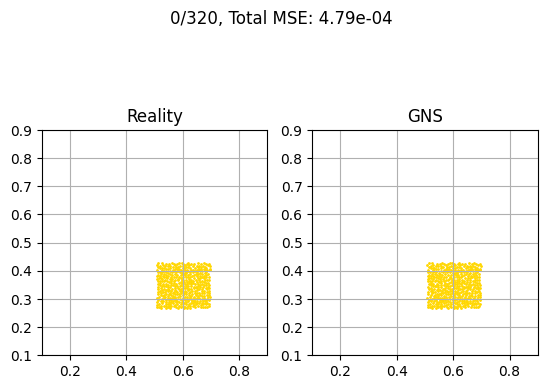

In [ ]:
import pickle
from absl import app
from absl import flags

from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import os
from pyevtk.hl import pointsToVTK

del_all_flags(flags.FLAGS)

flags.DEFINE_string("rollout_dir", "/content/drive/MyDrive/rollouts-106500_num_1_timestamp_100/train/", help="Directory where rollout.pkl are located")
flags.DEFINE_string("rollout_name", "rollout_ex1", help="Name of rollout `.pkl` file")
flags.DEFINE_integer("step_stride", 3, help="Stride of steps to skip.")
flags.DEFINE_bool("change_yz", False, help="Change y and z axis.")
flags.DEFINE_enum("output_mode", "gif", ["gif", "vtk"], help="Type of render output")

FLAGS = flags.FLAGS
FLAGS(sys.argv[1:])

TYPE_TO_COLOR = {
    1: "red",  # for droplet
    3: "black",  # Boundary particles.
    0: "green",  # Rigid solids.
    7: "magenta",  # Goop.
    6: "gold",  # Sand.
    5: "blue",  # Water.
}


class Render():
    def __init__(self, input_dir, input_name):
        # Texts to describe rollout cases for data and render
        rollout_cases = [
            ["ground_truth_rollout", "Reality"], ["predicted_rollout", "GNS"]]
        self.rollout_cases = rollout_cases
        self.input_dir = input_dir
        self.input_name = input_name
        self.output_dir = input_dir
        self.output_name = input_name

        # Get trajectory
        with open(f"{self.input_dir}{self.input_name}.pkl", "rb") as file:
            rollout_data = pickle.load(file)
        self.rollout_data = rollout_data
        trajectory = {}
        for rollout_case in rollout_cases:
            trajectory[rollout_case[0]] = np.concatenate(
                [rollout_data["initial_positions"], rollout_data[rollout_case[0]]], axis=0
            )
        self.trajectory = trajectory
        self.loss = self.rollout_data['loss'].item()

        # Trajectory information
        self.dims = trajectory[rollout_cases[0][0]].shape[2]
        self.num_particles = trajectory[rollout_cases[0][0]].shape[1]
        # self.num_steps = 100
        self.num_steps = trajectory[rollout_cases[0][0]].shape[0]
        self.boundaries = rollout_data["metadata"]["bounds"]
        self.particle_type = rollout_data["particle_types"]

    def color_map(self):
        # color mask for visualization for different material types
        color_map = np.empty(self.num_particles, dtype="object")
        for material_id, color in TYPE_TO_COLOR.items():
            print(material_id, color)
            color_index = np.where(np.array(self.particle_type) == material_id)
            print(color_index)
            color_map[color_index] = color
        color_map = list(color_map)
        return color_map

    def color_mask(self):
        color_mask = []
        for material_id, color in TYPE_TO_COLOR.items():
            mask = np.array(self.particle_type) == material_id
            if mask.any() == True:
                color_mask.append([mask, color])
        return color_mask

    def render_gif_animation(
            self, point_size=1, timestep_stride=3, vertical_camera_angle=20, viewpoint_rotation=0.5, change_yz=False
    ):
        # Init figures
        fig = plt.figure()
        if self.dims == 2:
            ax1 = fig.add_subplot(1, 2, 1, projection='rectilinear')
            ax2 = fig.add_subplot(1, 2, 2, projection='rectilinear')
            axes = [ax1, ax2]
        elif self.dims == 3:
            ax1 = fig.add_subplot(1, 2, 1, projection='3d')
            ax2 = fig.add_subplot(1, 2, 2, projection='3d')
            axes = [ax1, ax2]

        # Define datacase name
        trajectory_datacases = [self.rollout_cases[0][0], self.rollout_cases[1][0]]
        render_datacases = [self.rollout_cases[0][1], self.rollout_cases[1][1]]

        # Get boundary of simulation
        xboundary = self.boundaries[0]
        yboundary = self.boundaries[1]
        if self.dims == 3:
            zboundary = self.boundaries[2]

        # Get color mask for visualization
        color_mask = self.color_mask()

        # Fig creating function for 2d
        if self.dims == 2:
            def animate(i):
                print(f"Render step {i}/{self.num_steps}")

                fig.clear()
                for j, datacase in enumerate(trajectory_datacases):
                    # select ax to plot at set boundary
                    axes[j] = fig.add_subplot(1, 2, j + 1, autoscale_on=False)
                    axes[j].set_aspect("equal")
                    axes[j].set_xlim([float(xboundary[0]), float(xboundary[1])])
                    axes[j].set_ylim([float(yboundary[0]), float(yboundary[1])])
                    for mask, color in color_mask:
                        axes[j].scatter(self.trajectory[datacase][i][mask, 0],
                                        self.trajectory[datacase][i][mask, 1], s=point_size, color=color)
                    axes[j].grid(True, which='both')
                    axes[j].set_title(render_datacases[j])
                fig.suptitle(f"{i}/{self.num_steps}, Total MSE: {self.loss:.2e}")

        # Fig creating function for 3d
        elif self.dims == 3:


        # Creat animation
        ani = animation.FuncAnimation(
            fig, animate, frames=np.arange(0, self.num_steps, timestep_stride), interval=10)

        ani.save(f'{self.output_dir}{self.output_name}.gif', dpi=100, fps=30, writer='imagemagick')
        print(f"Animation saved to: {self.output_dir}{self.output_name}.gif")

    def write_vtk(self):
        """
        Write `.vtk` files for each timestep for each rollout case.
        """
        for rollout_case, label in self.rollout_cases:
            path = f"{self.output_dir}{self.output_name}_vtk-{label}"
            if not os.path.exists(path):
                os.makedirs(path)
            initial_position = self.trajectory[rollout_case][0]
            for i, coord in enumerate(self.trajectory[rollout_case]):
                disp = np.linalg.norm(coord - initial_position, axis=1)
                pointsToVTK(f"{path}/points{i}",
                            np.array(coord[:, 0]),
                            np.array(coord[:, 1]),
                            np.zeros_like(coord[:, 1]) if self.dims == 2 else np.array(coord[:, 2]),
                            data={"displacement": disp})
        print(f"vtk saved to: {self.output_dir}{self.output_name}...")


def main():
    if not FLAGS.rollout_dir:
        raise ValueError("A `rollout_dir` must be passed.")
    if not FLAGS.rollout_name:
        raise ValueError("A `rollout_name`must be passed.")

    render = Render(input_dir=FLAGS.rollout_dir, input_name=FLAGS.rollout_name)

    if FLAGS.output_mode == "gif":
        render.render_gif_animation(
            point_size=1,
            timestep_stride=FLAGS.step_stride,
            vertical_camera_angle=20,
            viewpoint_rotation=0.3,
            change_yz=FLAGS.change_yz
        )
    elif FLAGS.output_mode == "vtk":
        render.write_vtk()

main()